In [16]:
import re
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from gcpy import single_panel
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import regionmask
import seaborn as sns
import xarray as xr

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Original simulations 
variable = "EmisNO_Anthro"
w10 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.w10_ref_c48.EmisNO_Anthro.april-august.2000.nc4")
w10_ozoneseason = w10['EmisNO_Anthro'].isel(time=w10.time.dt.month.isin([4,5,6,7,8]))

In [18]:
w10_ozoneseason_mean = w10_ozoneseason.mean(dim='time')

In [19]:
def calculate_regional_mean(da, region, resolution='c48'):
    """
    Calculate the mean and standard deviation for a specific region and month.
    """
    if resolution == 'c48':
        cropped_da = tools.crop_regionmask_ar6_c48(da, region_num=ar6_region[region])
    elif resolution == 'c90':
        cropped_da = tools.crop_regionmask_ar6_c90(da, region_num=ar6_region[region])
    elif resolution == 'latlon':
        cropped_da = crop_regionmask_ar6(da, region_num=ar6_region[region])

    if 'nf' in cropped_da.dims:
        regional_mean = cropped_da.mean(dim=['nf', 'Ydim', 'Xdim'])
    if 'lat' in cropped_da.dims:
        regional_mean = cropped_da.mean(dim=['lat', 'lon'])
    return np.mean(regional_mean*1000 * (14/30)  * 86400 * (365.25)).values #gN/m2/yr

In [20]:
ar6_region = {
        "ENA": 5,
        "EAS": 58,
        "WCE": 17,
    }

In [21]:
ena = calculate_regional_mean(w10_ozoneseason, "ENA", resolution='c48')
wce = calculate_regional_mean(w10_ozoneseason, "WCE", resolution='c48')
eas = calculate_regional_mean(w10_ozoneseason, "EAS", resolution='c48')

In [22]:
# Print mean anthropogenic NOx emissions for each region (reported in Methods)
print(ena)
print(wce)
print(eas)

0.280806107024285
0.3489212478416114
1.4997813290736919


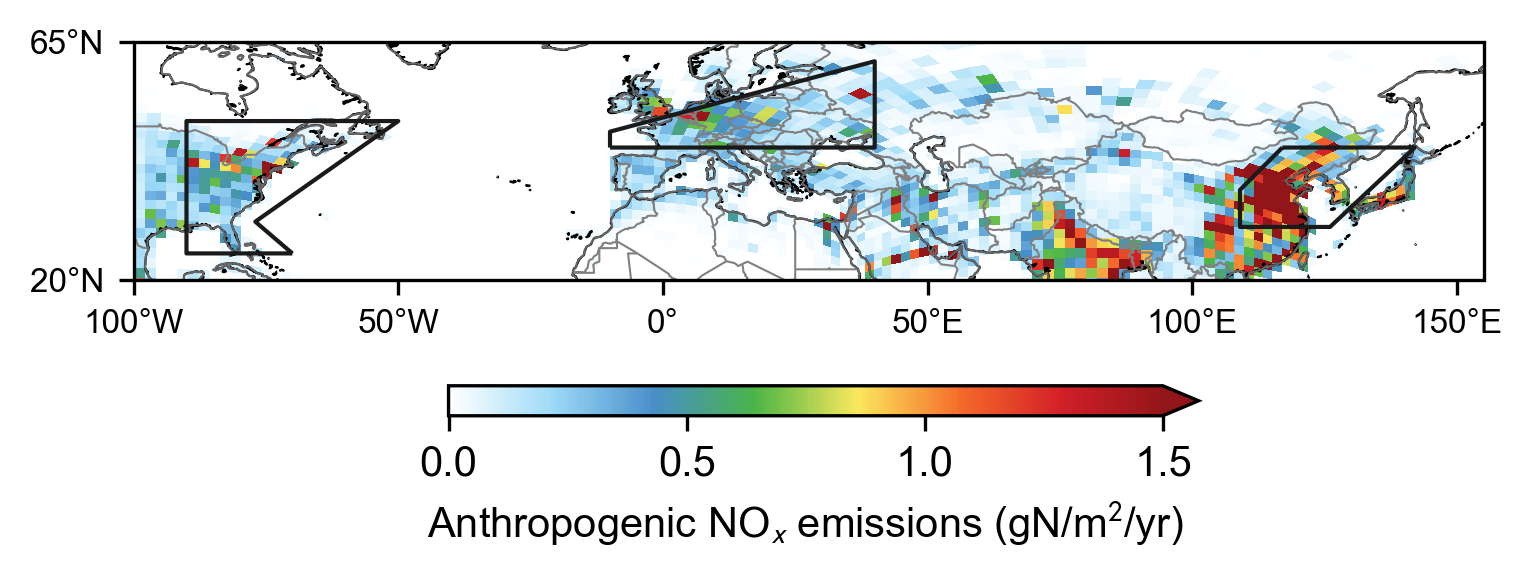

In [24]:
tools.set_matplotlib_font("Arial")

fig_width_in = 5
fig_height_in = 2

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 1, top=1.15, bottom=0.20, left=0.09, right=0.99, hspace=0.6, wspace=0.2)
ax = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=0))

cmap = cmaps.WhiteBlueGreenYellowRed
cmap = cmaps.WhiteBlueGreenYellowRed

for idx, z in enumerate([w10_ozoneseason_mean]):
    # Plot
    plot = single_panel(plot_vals=z*1e10, 
                ax=ax, gridtype="cs", 
                comap=cmap,
                extent=(-100, 155, 20, 65), 
                unit="ppbv",
                log_color_scale=False,
                vmin=0, vmax=1.5,
                add_cb=False)

    # Map features
    ax.coastlines(color="black", linewidth=0.5)
    country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
    ax.add_feature(country_borders, edgecolor="gray", linewidth=0.5)
    ax.set_extent([-100, 155, 20, 65], crs=ccrs.PlateCarree())

    # Xticks and Yticks
    ax.set_xticks([-100, -50, 0, 50, 100, 150])
    ax.set_xticklabels(
            ['100°W', '50°W', '0°', '50°E', '100°E', '150°E'], fontsize=8)   
    ax.set_yticks([20,65])
    ax.set_yticklabels(
            ['20°N', '65°N'], fontsize=8)

    # Add boxes around the IPCC AR6 regions
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot(ax=ax,
        add_ocean=False,
        projection=ccrs.PlateCarree(),
        add_label=False,
        line_kws=dict(lw=1)
    )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [126,30],[142,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax, line_kws=dict(lw=1))

ax.set_title(None)

# Colobar
cbar_ax = fig.add_axes([0.30, 0.25, 0.50, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label='Anthropogenic NO$_x$ emissions (gN/m$^2$/yr)',
                    extend='max'
                    )

plt.savefig("FigS1_new.png")

##########
plt.show()

In [25]:
# Print present and future soil NO emissions (reported in Section 3.6, see Google Doc table for percent calculations)

In [26]:
# Original simulations 
w10 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w10_ref_c48.Emissions.nc4")
w13 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w13_ref_c48.Emissions.nc4")
w14 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w14_ref_c48.Emissions.nc4")
w26 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w26_ref_c48.Emissions.nc4")
w28 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w28_ref_c48.Emissions.nc4")

wREF = xr.concat([w10, w13, w14, w26, w28], dim='sim')

wREF_ozoneseason = wREF['EmisNO_Soil'].isel(time=wREF.time.dt.month.isin([4,5,6,7,8]))
wREF_ozoneseason_mean = wREF_ozoneseason.mean(dim='time')
ena_soilNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "ENA", resolution='c48')
wce_soilNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "WCE", resolution='c48')
eas_soilNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "EAS", resolution='c48')
print("Present: Soil NO Emissions") #reported in Section 3.6
print(ena_soilNO_p, wce_soilNO_p, eas_soilNO_p)

Present: Soil NO Emissions
0.0689897010175855 0.16210954630508922 0.08522463847310036


In [27]:
wREF_ozoneseason = wREF['EmisNO_Total'].isel(time=wREF.time.dt.month.isin([4,5,6,7,8]))
wREF_ozoneseason_mean = wREF_ozoneseason.mean(dim='time')
ena_totNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "ENA", resolution='c48')
wce_totNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "WCE", resolution='c48')
eas_totNO_p = calculate_regional_mean(wREF_ozoneseason_mean, "EAS", resolution='c48')
print("Present: Total NO Emissions")
print(ena_totNO_p, wce_totNO_p, eas_totNO_p)

Present: Total NO Emissions
0.3543009968085187 0.5269967832182942 1.600467963214669


In [28]:
w10 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w10_refshort_c48.Emissions.nc4")
w13 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w13_refshort_c48.Emissions.nc4")
w14 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w14_refshort_c48.Emissions.nc4")
w26 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w26_refshort_c48.Emissions.nc4")
w28 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w28_refshort_c48.Emissions.nc4")

wREFSHORT = xr.concat([w10, w13, w14, w26, w28], dim='sim')

wREFSHORT_ozoneseason = wREFSHORT['EmisNO_Soil'].isel(time=wREFSHORT.time.dt.month.isin([4,5,6,7,8]))
wREFSHORT_ozoneseason_mean = wREFSHORT_ozoneseason.mean(dim='time')
ena_soilNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "ENA", resolution='c48')
wce_soilNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "WCE", resolution='c48')
eas_soilNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "EAS", resolution='c48')
print("Future: Soil NO Emissions") #reported in Section 3.6
print(ena_soilNO_f, wce_soilNO_f, eas_soilNO_f)

Future: Soil NO Emissions
0.07950310833926721 0.26760803289306523 0.11574161659520854


In [29]:
wREFSHORT_ozoneseason = wREFSHORT['EmisNO_Total'].isel(time=wREFSHORT.time.dt.month.isin([4,5,6,7,8]))
wREFSHORT_ozoneseason_mean = wREFSHORT_ozoneseason.mean(dim='time')
ena_totNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "ENA", resolution='c48')
wce_totNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "WCE", resolution='c48')
eas_totNO_f = calculate_regional_mean(wREFSHORT_ozoneseason_mean, "EAS", resolution='c48')
print("Future: Total NO Emissions")
print(ena_totNO_f, wce_totNO_f, eas_totNO_f)

Future: Total NO Emissions
0.36502908495947395 0.6324343352400774 1.6310132111635767


In [30]:
# Percent increase in soil NO emissions - reported in section 3.6
print(((ena_soilNO_f-ena_soilNO_p)/ena_soilNO_p)*100)
print(((wce_soilNO_f-wce_soilNO_p)/wce_soilNO_p)*100)
print(((eas_soilNO_f-eas_soilNO_p)/eas_soilNO_p)*100)

15.23909680229204
65.07851572752445
35.80769442834343


In [31]:
# Soil NO as a fraction of total NO - reported in section 3.6
print((ena_soilNO_p/ena_totNO_p)*100)
print((ena_soilNO_f/ena_totNO_f)*100)

print((wce_soilNO_p/wce_totNO_p)*100)
print((wce_soilNO_f/wce_totNO_f)*100)

print((eas_soilNO_p/eas_totNO_p)*100)
print((eas_soilNO_f/eas_totNO_f)*100)

19.472059531029448
21.77993798715896
30.761012489508822
42.313963360556464
5.324982469622184
7.096301599705476
